<a href="https://colab.research.google.com/github/Taweilo/loan_prediction/blob/main/Credit_Risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loan prediction

In [59]:
! pip install scikit-learn==1.3.2
! pip install optuna

In [60]:
# data preparation
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler

# modeling
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, cross_val_score, KFold
from sklearn.metrics import classification_report, accuracy_score,roc_auc_score, roc_curve


from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay


## 1. Import data

In [61]:
url = "https://raw.githubusercontent.com/Taweilo/credit_risk_modeling/main/loan_data.csv"
df = pd.read_csv(url)
df.head()

,application_id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,1,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,2,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,3,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,4,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,5,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [62]:
print(df.shape)
print("")
print(df.describe())

(32581, 13)

       application_id    person_age  person_income  person_emp_length  \
count    32581.000000  32581.000000   3.258100e+04       31686.000000   
mean     16291.000000     27.734600   6.607485e+04           4.789686   
std       9405.468897      6.348078   6.198312e+04           4.142630   
min          1.000000     20.000000   4.000000e+03           0.000000   
25%       8146.000000     23.000000   3.850000e+04           2.000000   
50%      16291.000000     26.000000   5.500000e+04           4.000000   
75%      24436.000000     30.000000   7.920000e+04           7.000000   
max      32581.000000    144.000000   6.000000e+06         123.000000   

          loan_amnt  loan_int_rate   loan_status  loan_percent_income  \
count  32581.000000   29465.000000  32581.000000         32581.000000   
mean    9589.371106      11.011695      0.218164             0.170203   
std     6322.086646       3.240459      0.413006             0.106782   
min      500.000000       5.420000   

In [63]:
print(df.info())
print("")
# Assuming df is your DataFrame
object_cols = df.select_dtypes(include='object').columns
for col in object_cols:
    print(f"Column '{col}' has data type 'object'.")
    unique_values = df[col].unique()
    print("Unique values:")
    for val in unique_values:
        print(val)
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   application_id              32581 non-null  int64  
 1   person_age                  32581 non-null  int64  
 2   person_income               32581 non-null  int64  
 3   person_home_ownership       32581 non-null  object 
 4   person_emp_length           31686 non-null  float64
 5   loan_intent                 32581 non-null  object 
 6   loan_grade                  32581 non-null  object 
 7   loan_amnt                   32581 non-null  int64  
 8   loan_int_rate               29465 non-null  float64
 9   loan_status                 32581 non-null  int64  
 10  loan_percent_income         32581 non-null  float64
 11  cb_person_default_on_file   32581 non-null  object 
 12  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(6), object

In [64]:
print("How many customers whose employment length are above 40 years: ",len(df[df['person_emp_length']>40]))
print("")
print(df[df['person_emp_length']>40]['person_emp_length'])

How many customers whose employment length are above 40 years:  3

0        123.0
210      123.0
32355     41.0
Name: person_emp_length, dtype: float64


In [65]:
print("How many customers are above 100 years old: ",len(df[df['person_age']>100]))
print("")
print(df[df['person_age']>100]['person_age'])

How many customers are above 100 years old:  5

81       144
183      144
575      123
747      123
32297    144
Name: person_age, dtype: int64


In [66]:
df.loan_status.value_counts()

,count
loan_status,
0,25473
1,7108


Data issue:<br>
1. no need of application ID
2. missing data: person_emp_length, loan_int_rate
3. data quality: employment lenght and age above 100 years are abnormal
4. imbalance data: nondefault data is more than three times of default data

In [67]:
# drop ID
df = df.drop(["application_id"], axis = 1)


In [68]:
# Create the cross table for loan status, home ownership, and the max employment length
print(pd.crosstab(df['loan_status'],df['person_home_ownership'],
                  values=df['person_emp_length'], aggfunc='max'))

# Create an array of indices where employment length is greater than 100
indices = df[df['person_emp_length'] > 100].index

# Drop the records from the data based on the indices and create a new dataframe
df_new = df.drop(indices)

person_home_ownership  MORTGAGE  OTHER   OWN   RENT
loan_status                                        
0                         123.0   24.0  31.0   41.0
1                          34.0   11.0  17.0  123.0


In [69]:
# Use Pandas to drop the record from the data frame and create a new one
df_new = df.drop(df[df["person_age"] > 100].index)


In [70]:
print(pd.crosstab(df_new["loan_intent"], df["loan_status"], margins = True))

loan_status            0     1    All
loan_intent                          
DEBTCONSOLIDATION   3722  1490   5212
EDUCATION           5340  1111   6451
HOMEIMPROVEMENT     2664   941   3605
MEDICAL             4450  1621   6071
PERSONAL            4422  1098   5520
VENTURE             4870   847   5717
All                25468  7108  32576


Index(['person_emp_length', 'loan_int_rate'], dtype='object')
     person_age  person_income person_home_ownership  person_emp_length  \
105          22          12600              MORTGAGE                NaN   
222          24         185000              MORTGAGE                NaN   
379          24          16800              MORTGAGE                NaN   
407          25          52000                  RENT                NaN   
408          22          17352              MORTGAGE                NaN   

           loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
105           PERSONAL          A       2000           5.42            1   
222          EDUCATION          B      35000          12.42            0   
379  DEBTCONSOLIDATION          A       3900            NaN            1   
407           PERSONAL          B      24000          10.74            1   
408          EDUCATION          C       2250          15.27            0   

     loan_percent_income cb_pe

<ipython-input-71-a954cf6c169d>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_new["person_emp_length"].fillna((df_new['person_emp_length'].median()), inplace=True)


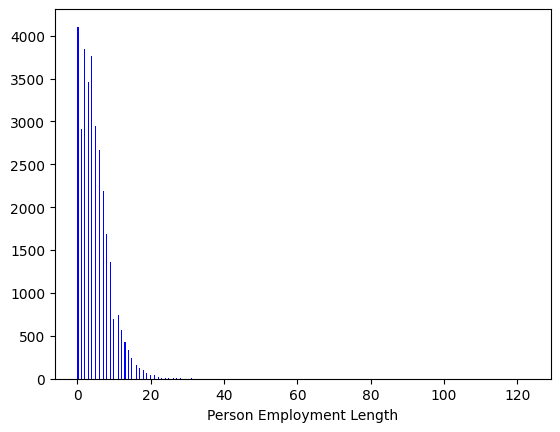

In [71]:
# Print a null value column array
print(df_new.columns[df_new.isnull().any()])

# Print the top five rows with nulls for employment length
print(df_new[df_new["person_emp_length"].isnull()].head())

# Impute the null values with the median value for all employment lengths
df_new["person_emp_length"].fillna((df_new['person_emp_length'].median()), inplace=True)

# Create a histogram of employment length
n, bins, patches = plt.hist(df_new["person_emp_length"], bins='auto', color='blue')
plt.xlabel("Person Employment Length")
plt.show()

In [72]:
# Print the number of nulls
print(df_new["loan_int_rate"].isnull().sum())

# Store the array on indices
indices = df_new[df_new["loan_int_rate"].isnull()].index

# Save the new data without missing data
df_clean = df_new.drop(indices)

3115


In [73]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29461 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  29461 non-null  int64  
 1   person_income               29461 non-null  int64  
 2   person_home_ownership       29461 non-null  object 
 3   person_emp_length           29461 non-null  float64
 4   loan_intent                 29461 non-null  object 
 5   loan_grade                  29461 non-null  object 
 6   loan_amnt                   29461 non-null  int64  
 7   loan_int_rate               29461 non-null  float64
 8   loan_status                 29461 non-null  int64  
 9   loan_percent_income         29461 non-null  float64
 10  cb_person_default_on_file   29461 non-null  object 
 11  cb_person_cred_hist_length  29461 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 2.9+ MB


## Data preparation
1. Define X, y
2. Split data (train 0.4, val 0.3, test 0.3)
3. Undersampling data

In [74]:
X = df_clean.drop('loan_status', axis=1)  # 'loan_status' is the target column
X = pd.get_dummies(X, drop_first=True)  # Set drop_first=True to avoid multicollinearity
y = df_clean['loan_status']

In [75]:
X.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,...,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y
0,22,59000,123.0,35000,16.02,0.59,3,False,False,True,...,False,True,False,False,False,True,False,False,False,True
1,21,9600,5.0,1000,11.14,0.10,2,False,True,False,...,False,False,False,True,False,False,False,False,False,False
2,25,9600,1.0,5500,12.87,0.57,3,False,False,False,...,True,False,False,False,True,False,False,False,False,False
3,23,65500,4.0,35000,15.23,0.53,2,False,False,True,...,True,False,False,False,True,False,False,False,False,False
4,24,54400,8.0,35000,14.27,0.55,4,False,False,True,...,True,False,False,False,True,False,False,False,False,True


In [76]:
# Splitting the data into training and temporary sets
X_train, X_tem, y_train, y_tem = train_test_split(X, y, test_size=0.4, random_state=123)
X_val, X_test, y_val, y_test = train_test_split(X_tem, y_tem, test_size=0.5, random_state=123)

In [77]:
# Check the class distribution before undersampling
print("Before Undersampling:", Counter(y_train))

Before Undersampling: Counter({0: 13807, 1: 3869})


In [78]:
# Initialize the RandomUnderSampler
undersampler = RandomUnderSampler(random_state=42)

# Perform undersampling on train_X and train_y
X_train_undersampled, y_train_undersampled = undersampler.fit_resample(X_train, y_train)

# Check the class distribution after undersampling
print("After Undersampling:", Counter(y_train_undersampled))


After Undersampling: Counter({0: 3869, 1: 3869})


In [79]:
# rename original train data
X_old_train = X_train
y_old_train = y_train

# rename undersampling train data
X_train = X_train_undersampled
y_train = y_train_undersampled

In [80]:
# set of train data
print(X_old_train.shape)
print(y_old_train.shape)
print(X_train.shape)
print(y_train.shape)
# validation data
print(X_val.shape)
print(y_val.shape)
# test data
print(X_test.shape)
print(y_test.shape)

(17676, 22)
(17676,)
(7738, 22)
(7738,)
(5892, 22)
(5892,)
(5893, 22)
(5893,)


## Modeling
- Logistic regression
- Decision tree
- XGB

1. Logistic regression

In [81]:
# Initialize StandardScaler
scaler = StandardScaler()

# Fit on training data and transform both training and validation sets
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [82]:
# logit model
log_model=LogisticRegression(solver='lbfgs')
log_model.fit(X_train_scaled, np.ravel(y_train))
y_log_pred = log_model.predict(X_val_scaled)
y_log_pred_prob =log_model.predict_proba(X_val_scaled)[:, 1]

# Calculate accuracy score
acc_log = accuracy_score(y_val, y_log_pred)
print("Accuracy score:", acc_log)

Accuracy score: 0.8070264765784114


In [83]:
# Set logging to ERROR to suppress INFO messages from Optuna
optuna.logging.set_verbosity(optuna.logging.ERROR)

# Define Optuna objective function
def objective(trial):
    # Suggest hyperparameters
    C = trial.suggest_loguniform('C', 1e-4, 1e2)  # Regularization strength
    solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'saga'])  # Solver selection
    penalty = 'l2' if solver in ['lbfgs', 'saga'] else trial.suggest_categorical('penalty', ['l1', 'l2'])  # Solver-penalty compatibility

    # Create Logistic Regression model
    log_model = LogisticRegression(C=C, solver=solver, penalty=penalty, max_iter=1000, random_state=42)

    # Stratified K-Fold cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracy_scores = cross_val_score(log_model, X_train_scaled, np.ravel(y_train), cv=skf, scoring='accuracy')

    # Pruning logic: Report intermediate results
    trial.report(accuracy_scores.mean(), step=1)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return accuracy_scores.mean()  # Return mean accuracy score

# Create Optuna study with pruning
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=50)  # Increase trials for better tuning

# Get the best parameters
best_params = study.best_params
print("Best hyperparameters found by Optuna:", best_params)

<ipython-input-83-05166508794d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-4, 1e2)  # Regularization strength
<ipython-input-83-05166508794d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-4, 1e2)  # Regularization strength
<ipython-input-83-05166508794d>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-4, 1e2)  # Regularization strength
<ipython-input-83-05166508794d>:7: FutureWarning: suggest_

Best hyperparameters found by Optuna: {'C': 1.1162577880315152, 'solver': 'lbfgs'}


In [84]:
# Train Logistic Regression with best hyperparameters
log_model = LogisticRegression(**best_params, max_iter=1000)
log_model.fit(X_train_scaled, np.ravel(y_train))
y_log_pred = log_model.predict(X_val_scaled )
y_log_pred_prob =log_model.predict_proba(X_val_scaled)[:, 1]

# Calculate accuracy score
acc_log = accuracy_score(y_val, y_log_pred)
print("Accuracy score:", acc_log)

Accuracy score: 0.8070264765784114


2. Decision tree

In [85]:
# Decision tree model
# Initialize and train Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Make predictions
y_dt_pred = dt_model.predict(X_val)
y_dt_pred_prob = dt_model.predict_proba(X_val)[:, 1]

# Calculate accuracy score
acc_dt = accuracy_score(y_val, y_dt_pred)
print("Decision Tree Accuracy:", acc_dt)

Decision Tree Accuracy: 0.8015953835709436


In [86]:
from sklearn import tree  # Import tree module
# train decision tree
# with validation-based early stopping

# train 12 different models from depth 1 to depth 12
max_depth = 12
candidate_models = {}

# loop through depth and train a decision tree
for depth in range(0, max_depth):

  clf = tree.DecisionTreeClassifier(max_depth = depth + 1, random_state=123)    # instantiate model
  clf.fit(X_train, y_train)                                                      # training/fitting the classifier (cls)

  # get probabilities (y values) for each row of training data set and
  # validation data set
  train_phat = clf.predict_proba(X_train)[:, 1]
  valid_phat = clf.predict_proba(X_val)[:, 1]

  # ROC AUC - Compute Area Under the Receiver Operating Characteristic Curve is
  # a fixed statistic for binary classifier
  train_auc = roc_auc_score(y_train, train_phat)
  valid_auc = roc_auc_score(y_val, valid_phat)

  # decision trees are unstable
  # to check if the model is stable, break validation data into 5 sub-samples
  # and calculate AUC on each sub-sample.
  cv_scores = cross_val_score(clf, X_val, y_val, scoring='roc_auc', cv=5)
  cv_std = np.std(cv_scores) # standard-deviation

  # store results into a table
  candidate_models[depth + 1] = {}
  candidate_models[depth + 1]['Model'] = clf
  candidate_models[depth + 1]['Training AUC'] = train_auc
  candidate_models[depth + 1]['Validation AUC'] = valid_auc
  candidate_models[depth + 1]['5-Fold SD'] = cv_std

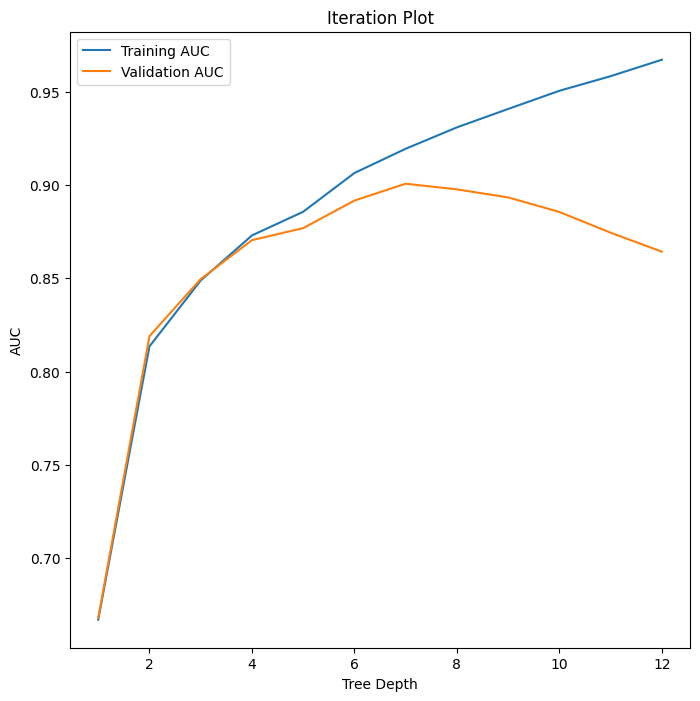

In [87]:
# plot tree depth vs. training and validation AUC

# create dataframe object from dictionary
candidate_results = pd.DataFrame.from_dict(candidate_models, orient='index')
# using pandas plotting and matplotlib
fig, ax = plt.subplots(figsize=(8, 8))
_ = candidate_results[['Training AUC', 'Validation AUC']].plot(title='Iteration Plot',
                                                               ax=ax)
_ = ax.set_xlabel('Tree Depth') # label x-axis as Tree Depth
_ = ax.set_ylabel('AUC')        # label y-axis as AUC

In [88]:
# view same results as a table, using pandas iloc to remove first column of table
candidate_results.iloc[:, 1:]
# From the table below, maximum validation AUC is at depth 7.

,Training AUC,Validation AUC,5-Fold SD
1,0.666839,0.667703,0.023674
2,0.813484,0.818995,0.008956
3,0.848848,0.849598,0.008789
4,0.873026,0.870496,0.007101
5,0.885735,0.876942,0.008749
6,0.906514,0.891734,0.004567
7,0.919522,0.900775,0.005835
8,0.931005,0.897746,0.004894
9,0.940883,0.893431,0.009309
10,0.950635,0.885625,0.013483


In [89]:
# Set logging to ERROR to suppress INFO messages from Optuna
optuna.logging.set_verbosity(optuna.logging.ERROR)

# Optuna objective function
def objective(trial):
    # Suggest hyperparameters
    max_depth = 7
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    ccp_alpha = trial.suggest_float('ccp_alpha', 0.0001, 0.05, log=True)  # Add pruning

    # Initialize Decision Tree with pruning
    dt_model = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion,
        ccp_alpha=ccp_alpha,  # Tree pruning
        random_state=42
    )

    # Stratified K-Fold cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(dt_model, X_train, y_train, cv=skf, scoring='accuracy')

    # Pruning logic (Optuna pruning)
    trial.report(np.mean(scores), step=1)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return np.mean(scores)  # Return average accuracy

# Create Optuna study with pruning
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=50)  # Increase n_trials for better results

# Get best parameters
best_params = study.best_params
print("Best hyperparameters found by Optuna:", best_params)

Best hyperparameters found by Optuna: {'min_samples_split': 10, 'min_samples_leaf': 4, 'criterion': 'gini', 'ccp_alpha': 0.00048534526568428174}


In [90]:
# Train Decision Tree with best hyperparameters
dt_model = DecisionTreeClassifier(**best_params, max_depth = 7, random_state=42)
dt_model.fit(X_train, y_train)

# Make predictions
y_dt_pred_prob =dt_model.predict_proba(X_val)[:, 1]
y_dt_pred = dt_model.predict(X_val)

# Evaluate model
acc_dt = accuracy_score(y_val, y_dt_pred)
print("Optimized Decision Tree Accuracy:", acc_dt)

Optimized Decision Tree Accuracy: 0.903428377460964


In [91]:
dt_model.predict_proba(X_val)[:, 1]

array([0.13333333, 0.25962326, 0.        , ..., 0.13333333, 0.25962326,
       1.        ])

3. XGB

In [92]:
# xgb model
# Define the XGBoost classifier
xgb_model = xgb.XGBClassifier()

# Train the model
xgb_model.fit(X_train, np.ravel(y_train))

# Make predictions on the test data
y_xgb_pred = xgb_model.predict(X_val)
y_xgb_pred_prob =xgb_model.predict_proba(X_val)[:, 1]

acc_xgb= accuracy_score(y_val, y_xgb_pred)
print("Accuracy score:", acc_xgb)

Accuracy score: 0.8810251188051595


In [93]:
# Set logging to ERROR to suppress INFO messages from Optuna
optuna.logging.set_verbosity(optuna.logging.ERROR)

# Define the Optuna objective function
def objective(trial):
    params = {
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-6, 10),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-6, 10),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "learning_rate": trial.suggest_loguniform('learning_rate', 1e-2, 1.0),
        "max_depth": trial.suggest_int('max_depth', 2, 50),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 1e-4, 100),
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
        "tree_method": "hist",  # Using GPU for speedup
        "device": "cuda",  # Use GPU
        "random_state": 42
    }

    # Initialize XGBoost Classifier
    model = xgb.XGBClassifier(**params, enable_categorical=True)

    # Cross-validation using KFold
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(xgb_model, X_train, y_train, cv=kf, scoring='accuracy')

    # Compute mean score
    mean_score = scores.mean()

    # Pruning logic: Report intermediate results
    trial.report(mean_score, step=1)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return mean_score

# Create a study and optimize
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=50)

# Get the best parameters
best_params = study.best_params
print("Best parameters found by Optuna: ", best_params)

<ipython-input-93-22c9a6b91acf>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-6, 10),
<ipython-input-93-22c9a6b91acf>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-6, 10),
<ipython-input-93-22c9a6b91acf>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform('learning_rate', 1e-2, 1.0),
<ipython-input-93-22c9a6b91acf>:13: FutureWarning: suggest_loguniform has be

Best parameters found by Optuna:  {'reg_lambda': 1.0806509368571158e-06, 'reg_alpha': 3.839238175972588e-06, 'colsample_bytree': 0.9455596343231498, 'subsample': 0.8147154153348259, 'learning_rate': 0.5205650140793474, 'max_depth': 27, 'min_child_weight': 26.545257389243105, 'n_estimators': 529}


In [94]:
# Define the XGBClassifier model with the best parameters
xgb_model = xgb.XGBClassifier(
    **best_params,
    enable_categorical=True,
    random_state=42,
    eval_metric="logloss",  # Use logloss for classification
    early_stopping_rounds=10  # Enable early stopping
)

# Train the model with early stopping using the validation set
eval_set = [(X_val, y_val)]
xgb_model.fit(X_train, y_train, eval_set=eval_set, verbose=0)

# Predict on the validation set
y_xgb_pred = xgb_model.predict(X_val)
# Predict class probabilities
y_xgb_pred_prob = xgb_model.predict_proba(X_val)[:, 1]

# Compute Accuracy
xgb_acc = accuracy_score(y_val, y_xgb_pred)

print(f"XGBoost Classifier Accuracy: {xgb_acc:.4f}")

XGBoost Classifier Accuracy: 0.8717


## Evaluation

In [95]:
# print classification report
# Print the logistic regression classification report
target_names = ['Non-Default', 'Default']
print("Loistic Regression")
print(classification_report(y_val, y_log_pred, target_names=target_names))
print("")

# Print the gradient boosted tree classification report
print("Decision tree classifier")
print(classification_report(y_val, y_dt_pred, target_names=target_names))

# Print the XGB classification report
print("XGB classifier")
print(classification_report(y_val, y_xgb_pred, target_names=target_names))


Loistic Regression
              precision    recall  f1-score   support

 Non-Default       0.93      0.82      0.87      4609
     Default       0.54      0.76      0.63      1283

    accuracy                           0.81      5892
   macro avg       0.73      0.79      0.75      5892
weighted avg       0.84      0.81      0.82      5892


Decision tree classifier
              precision    recall  f1-score   support

 Non-Default       0.93      0.95      0.94      4609
     Default       0.81      0.72      0.77      1283

    accuracy                           0.90      5892
   macro avg       0.87      0.84      0.85      5892
weighted avg       0.90      0.90      0.90      5892

XGB classifier
              precision    recall  f1-score   support

 Non-Default       0.95      0.89      0.92      4609
     Default       0.67      0.82      0.74      1283

    accuracy                           0.87      5892
   macro avg       0.81      0.85      0.83      5892
weighted avg  

In [96]:
# Calculate performance metrics
log_reg_accuracy = round(accuracy_score(y_val, y_log_pred), 2)
log_reg_auc = round(roc_auc_score(y_val, y_log_pred_prob), 2)
log_reg_f1 = round(f1_score(y_val, y_log_pred), 2)

dt_reg_accuracy = round(accuracy_score(y_val, y_dt_pred), 2)
dt_reg_auc = round(roc_auc_score(y_val, y_dt_pred_prob), 2)
dt_reg_f1 = round(f1_score(y_val, y_dt_pred), 2)

xgb_accuracy = round(accuracy_score(y_val, y_xgb_pred), 2)
xgb_auc = round(roc_auc_score(y_val, y_xgb_pred_prob), 2)
xgb_f1 = round(f1_score(y_val, y_xgb_pred), 2)

# Create a DataFrame
data = {
    'Model': ['Logistic Regression', 'Decision tree', 'XGB Classifier'],
    'Accuracy': [log_reg_accuracy, dt_reg_accuracy, xgb_accuracy],
    'AUC': [log_reg_auc, dt_reg_auc, xgb_auc],
    'F1': [log_reg_f1, dt_reg_f1, xgb_f1]
}
performance_df = pd.DataFrame(data)

# Set the Model column as the index
performance_df.set_index('Model', inplace=True)

print(performance_df)

                     Accuracy   AUC    F1
Model                                    
Logistic Regression      0.81  0.86  0.63
Decision tree            0.90  0.90  0.77
XGB Classifier           0.87  0.92  0.74


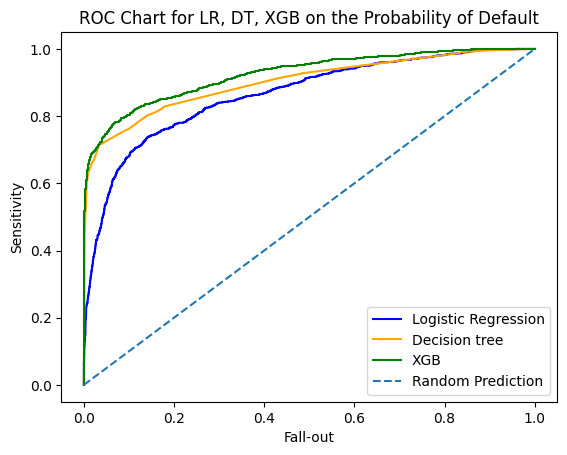

Logistic Regression AUC Score: 0.86
Decision tree AUC Score: 0.90
XGB Classifier AUC Score: 0.92


In [97]:
# ROC chart components
fallout_lr, sensitivity_lr, thresholds_lr = roc_curve(y_val, y_log_pred_prob)
fallout_dt, sensitivity_dt, thresholds_dt = roc_curve(y_val, y_dt_pred_prob)
fallout_gbt, sensitivity_gbt, thresholds_gbt = roc_curve(y_val, y_xgb_pred_prob)

# ROC Chart with both
plt.plot(fallout_lr, sensitivity_lr, color = 'blue', label='%s' % 'Logistic Regression')
plt.plot(fallout_dt, sensitivity_dt, color = 'orange', label='%s' % 'Decision tree')
plt.plot(fallout_gbt, sensitivity_gbt, color = 'green', label='%s' % 'XGB')
plt.plot([0, 1], [0, 1], linestyle='--', label='%s' % 'Random Prediction')
plt.title("ROC Chart for LR, DT, XGB on the Probability of Default")
plt.xlabel('Fall-out')
plt.ylabel('Sensitivity')
plt.legend()
plt.show()

# Print the logistic regression AUC with formatting
print("Logistic Regression AUC Score: %0.2f" % log_reg_auc)

# Print the logistic regression AUC with formatting
print("Decision tree AUC Score: %0.2f" % dt_reg_auc)

# Print the gradient boosted tree AUC with formatting
print("XGB Classifier AUC Score: %0.2f" % xgb_auc)

In [116]:
import joblib
# Save the trained model to a file
joblib.dump(dt_model, 'dt_model_optimized.pkl')

['dt_model_optimized.pkl']

Testing the performance

In [98]:
# Create a DataFrame with y_test
test_summary_df = pd.DataFrame(y_test)
test_summary_df = test_summary_df.rename(columns={'loan_status': 'true_loan_status'})
# Add two more columns from your predictions
y_dt_test_pred_prob= dt_model.predict_proba(X_test)[:, 1]
y_dt_test_pred = dt_model.predict(X_test)
test_summary_df['prob_default'] = y_dt_test_pred_prob
test_summary_df['pred_loan_status'] = y_dt_test_pred
test_summary_df['loan_amnt'] = X_test['loan_amnt']

print(test_summary_df ['loan_amnt'].describe())

count     5893.000000
mean      9592.393518
std       6250.730027
min        500.000000
25%       5000.000000
50%       8000.000000
75%      12000.000000
max      35000.000000
Name: loan_amnt, dtype: float64


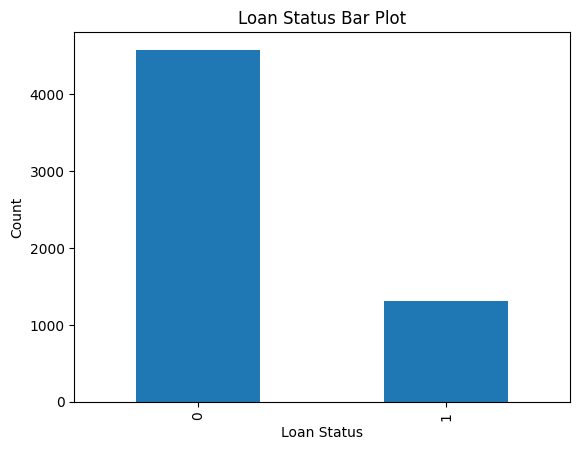

In [99]:
# Get the value counts of 'loan_status'
loan_status_counts = test_summary_df['true_loan_status'].value_counts()

# Plot the bar plot
loan_status_counts.plot(kind='bar')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.title('Loan Status Bar Plot')
plt.show()

In [100]:
# classification report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, y_dt_test_pred, target_names = target_names))

              precision    recall  f1-score   support

 Non-Default       0.92      0.96      0.94      4581
     Default       0.82      0.73      0.77      1312

    accuracy                           0.90      5893
   macro avg       0.87      0.84      0.86      5893
weighted avg       0.90      0.90      0.90      5893



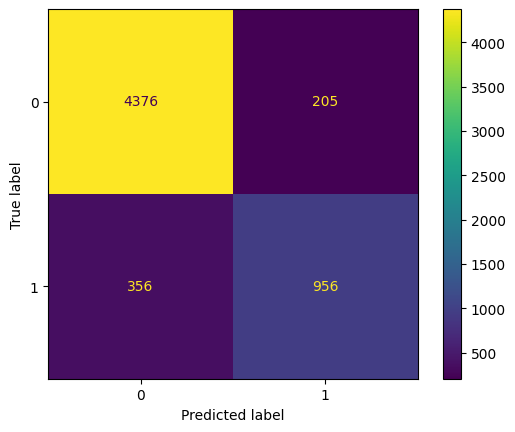

In [101]:
# confusion matrix
cm = confusion_matrix(y_test, y_dt_test_pred, labels=dt_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=dt_model.classes_)
disp.plot()
plt.show()

In [102]:
# Print or view the DataFrame
print(test_summary_df)

       true_loan_status  prob_default  pred_loan_status  loan_amnt
16239                 0      0.931034                 1       7000
8358                  1      0.803922                 1       7500
14335                 1      1.000000                 1      14500
8104                  0      0.000000                 0      11000
366                   1      1.000000                 1       4375
...                 ...           ...               ...        ...
3555                  0      0.133333                 0       6000
29983                 0      0.097959                 0       8400
28591                 0      0.133333                 0       5000
28763                 0      0.259623                 0      11000
23700                 0      0.133333                 0       9200

[5893 rows x 4 columns]


(array([ 753., 1752., 1538.,  194.,  495.,   66.,    0.,   93.,  103.,
         899.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

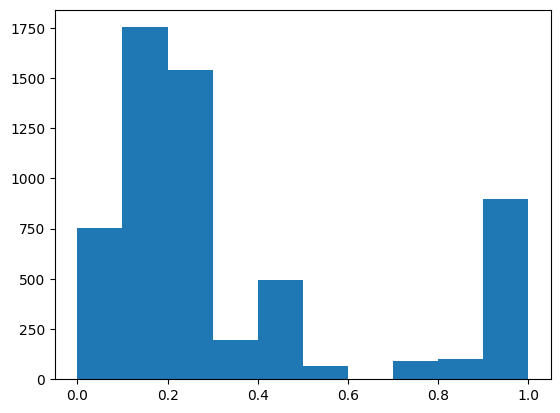

In [103]:
plt.hist(test_summary_df['prob_default'])

In [104]:
## Acceptance rate impact

# Print the statistics of the loan amount column
print(test_summary_df ['loan_amnt'].describe())
print("")
# Store the average loan amount
avg_loan = np.mean(test_summary_df ['loan_amnt'])

# Set the formatting for currency, and print the cross tab
pd.options.display.float_format = '${:,.2f}'.format
print(pd.crosstab(test_summary_df ['true_loan_status'],
                 test_summary_df ['pred_loan_status']).apply(lambda x: x * avg_loan, axis = 0))

count     5893.000000
mean      9592.393518
std       6250.730027
min        500.000000
25%       5000.000000
50%       8000.000000
75%      12000.000000
max      35000.000000
Name: loan_amnt, dtype: float64

pred_loan_status              0             1
true_loan_status                             
0                $41,976,314.03 $1,966,440.67
1                 $3,414,892.09 $9,170,328.20


In [105]:
# Reset the format to non-currency format
pd.options.display.float_format = None
# Making the strategy table

accept_rates = [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55,
                0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05]

# Create lists to store thresholds and bad rates
thresholds = []
bad_rates = []

# Populate the arrays for the strategy table with a for loop
for rate in accept_rates:

    # Calculate the threshold for the acceptance rate
    thresh = np.quantile(test_summary_df['prob_default'], \
                         rate).round(3)

    # Add the threshold value to the list of thresholds
    thresholds.append(np.quantile(test_summary_df['prob_default'],\
                                  rate).round(3))

    # Reassign the loan_status value using the threshold
    test_summary_df['pred_loan_status'] = test_summary_df['prob_default']\
                                        .apply(lambda x: 1 if x > thresh else 0)

    # Create a set of accepted loans using this acceptance rate
    accepted_loans = test_summary_df[test_summary_df['pred_loan_status'] == 0]

    # Calculate and append the bad rate using the acceptance rate
    bad_rates.append(np.sum((accepted_loans['true_loan_status']) /\
                            len(accepted_loans['true_loan_status'])).round(3))

# Create a data frame of the strategy table
strat_df = pd.DataFrame(zip(accept_rates, thresholds, bad_rates),
                        columns = ['Acceptance Rate','Threshold','Bad Rate'])

# Print the entire table
print(strat_df)

    Acceptance Rate  Threshold  Bad Rate
0              1.00      1.000     0.223
1              0.95      1.000     0.223
2              0.90      0.976     0.102
3              0.85      0.931     0.094
4              0.80      0.488     0.071
5              0.75      0.464     0.070
6              0.70      0.375     0.062
7              0.65      0.260     0.058
8              0.60      0.260     0.058
9              0.55      0.260     0.058
10             0.50      0.260     0.058
11             0.45      0.225     0.046
12             0.40      0.133     0.025
13             0.35      0.133     0.025
14             0.30      0.133     0.025
15             0.25      0.133     0.025
16             0.20      0.133     0.025
17             0.15      0.133     0.025
18             0.10      0.098     0.024
19             0.05      0.000     0.012


threshold 0.133 while acceptance rate is 0.4 seems to be a good choice

In [106]:
test_summary_df['pred_loan_status_o.4_tresh'] = (y_dt_test_pred_prob > 0.1333).astype(int)
test_summary_df['pred_loan_status_o.4_tresh']

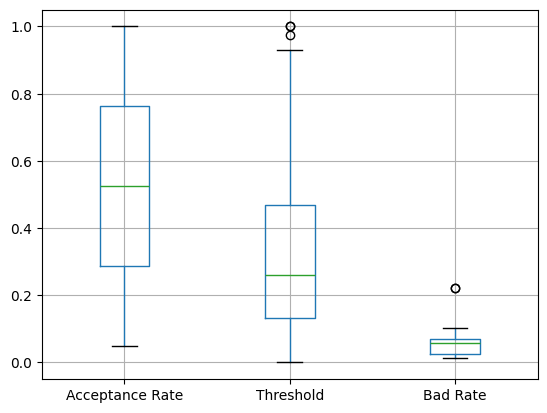

In [107]:
# Visualize the distributions in the strategy table with a boxplot
strat_df.boxplot()
plt.show()


In [108]:
# Initialize an empty list to store the number of accepted loans for each threshold
num_accepted_loans_list = []

# Iterate over each threshold in the 'Threshold' column of strat_df
for threshold in strat_df['Threshold']:
    # Compute binary predictions using the current threshold
    y_pred_non_default = (dt_model.predict_proba(X_test)[:, 1] < threshold).astype(int)

    # Count the number of accepted loans (where non-default is predicted)
    num_accepted_loans = np.sum(y_pred_non_default)

    # Append the count to the list
    num_accepted_loans_list.append(num_accepted_loans)

# Assign the list of counts to the 'Num Accepted Loans' column in strat_df
strat_df['Num Accepted Loans'] = num_accepted_loans_list

strat_df['Avg Loan Amnt'] = avg_loan

strat_df['Estimated Value'] = strat_df['Num Accepted Loans'] * strat_df['Avg Loan Amnt'] * (1-strat_df['Bad Rate']-strat_df['Bad Rate'])

In [109]:
print(strat_df)

    Acceptance Rate  Threshold  Bad Rate  Num Accepted Loans  Avg Loan Amnt  \
0              1.00      1.000     0.223                5312    9592.393518   
1              0.95      1.000     0.223                5312    9592.393518   
2              0.90      0.976     0.102                5064    9592.393518   
3              0.85      0.931     0.094                4994    9592.393518   
4              0.80      0.488     0.071                4525    9592.393518   
5              0.75      0.464     0.070                4477    9592.393518   
6              0.70      0.375     0.062                4072    9592.393518   
7              0.65      0.260     0.058                4043    9592.393518   
8              0.60      0.260     0.058                4043    9592.393518   
9              0.55      0.260     0.058                4043    9592.393518   
10             0.50      0.260     0.058                4043    9592.393518   
11             0.45      0.225     0.046            

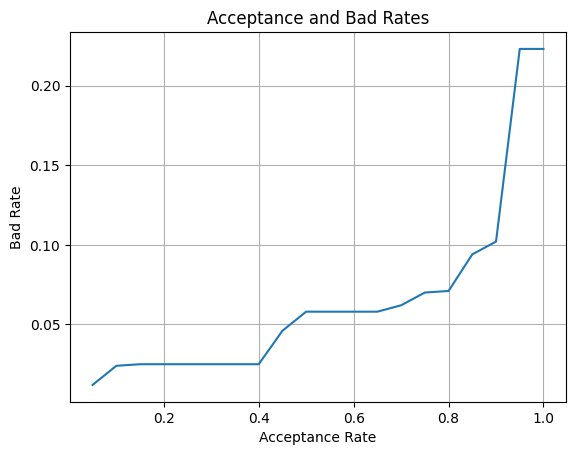

In [110]:
# Plot the strategy curve
plt.plot(strat_df['Acceptance Rate'],
         strat_df['Bad Rate'])
plt.xlabel('Acceptance Rate')
plt.ylabel('Bad Rate')
plt.title('Acceptance and Bad Rates')
plt.grid(True)  # Add grid lines
plt.show()